In [1]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods

In [2]:
def plot_train_vs_test(train_scores, test_scores, spoint, wo, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    plt.scatter(spoint[0], spoint[1], s=10, c='red')
    w = [-wo[1]/n_features, wo[0]]
    b = w[0]*spoint[0] + w[1]*spoint[1]
    xleft, xright = plt.xlim()
    xd = np.array([xleft, xright])
    yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
    plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [3]:
n_features = 300
X, y = make_classification(n_clusters_per_class = 2, n_samples = 9000, n_features = n_features, n_informative = 100, random_state=8, flip_y= 0.01)
X_train, X_test = np.split(X, [8000])
y_train, y_test = np.split(y, [8000])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Normal

In [4]:
@time_func
def SVM_RFE_W_STEP(step, w1 = [0.8, 0.2]):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe, index)

    # scores = list(map(data.svm_rfe, index))
    scores = list(scores)

    print(data.X_train.shape, index[0][0].shape, index[0][1].shape)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    

(8000, 300) (7600,) (400,)


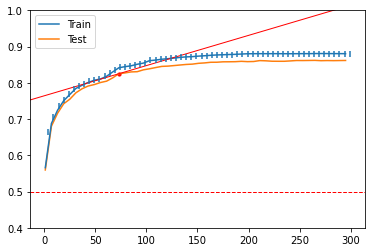

AT (73, 0.8251250000000001, 0.18856666666666658) WITH 60 ITERATIONS IN 30.86889930963516 SECONDS : 2.207036877928018
__main__.SVM_RFE_W_STEP - 00:02:57.458202000


In [5]:
SVM_RFE_W_STEP(5)

# SAMPLING OUTSIDE RFE

In [6]:
@time_func
def SVM_RFE_PRESAMPLE(step, percentage, w1 = [0.8, 0.2]):
    def Xresample(X0):
        return resample(X0, replace=False, n_samples = int(X0.shape[0]*percentage))

    kf = KFold(n_splits=20, shuffle=True)

    index = [(Xresample(train_index), test_index, step) for train_index, test_index in kf.split(data.X_train)]

    print(data.X_train.shape, index[0][0].shape, index[0][1].shape)

    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe, index)

    # scores = list(map(data.svm_rfe, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)

(8000, 300) (3800,) (400,)


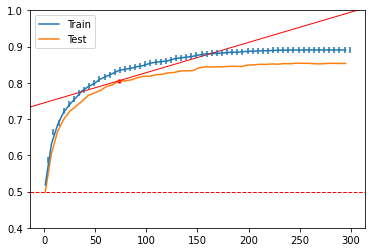

AT (73, 0.8057500000000001, 0.20406666666666662) WITH 60 ITERATIONS IN 16.256824135780334 SECONDS : 4.695064196288589
__main__.SVM_RFE_PRESAMPLE - 00:01:34.925125600


In [7]:
SVM_RFE_PRESAMPLE(5, 0.5)

# SAMPLING WITHIN RFE

In [8]:
@time_func
def SVM_RFE_SAMPLING(step, percentage = 0.5, w1 = [0.8, 0.2]):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(train_index, test_index, step, percentage) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_sampling, index)

    #scores = list(map(data.svm_rfe_sampling, index))
    scores = list(scores)

    print(data.X_train.shape, index[0][0].shape, index[0][1].shape)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)

(8000, 300) (7600,) (400,)


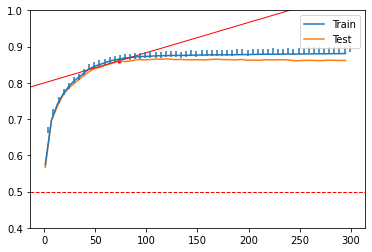

AT (73, 0.86075, 0.16006666666666666) WITH 60 ITERATIONS IN 19.636533296108247 SECONDS : 1.7542520139970823
__main__.SVM_RFE_SAMPLING - 00:02:39.896117400


In [9]:
SVM_RFE_SAMPLING(5, 0.5)